### Setup

In [2]:
# Load helpers and custom dataset class
from __init__ import (PricingWizardDataset, 
                      regression_accuracy, 
                      threshold_accuracy, 
                      ridge_regression_pipeline, 
                      base_regression_pipeline,
                      drop_helpers, 
                      save_model, 
                      train,
                      train_step,
                      test,
                      validation)

# Data manipulation 
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.data import Dataset, TensorDataset

In [3]:
# Data loading
data = PricingWizardDataset(
    filename = 'post_preprocessing_without_dummies.csv'
)

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


## Version 1
The first version will use the same preprocessing as the best performing regularized linear model

In [4]:
# Reset dataset, used during modelling and overwrites any previous changes
data.reset_dataset()

In [5]:
# Apply ridge regression pipeline
data.apply_function(ridge_regression_pipeline)

In [6]:
# Inspecting head
data.head()

,classified_id,log_listing_price,condition_name,brand_name_& Other Stories,brand_name_(di)vision,brand_name_66 North,brand_name_7 DAYS ACTIVE,brand_name_A.P.C.,brand_name_AF Agger,brand_name_AMI Paris,...,subsubsubcategory_name_Wall lights,subsubsubcategory_name_Wallets,subsubsubcategory_name_Watches,subsubsubcategory_name_Weekend bags,subsubsubcategory_name_Wireless speakers,subsubsubcategory_name_Women,subsubsubcategory_name_iPhone,subsubsubcategory_name_iPhones,subsubsubcategory_name_Øreringe,brand_name_other
0,30343099,7.170120,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30346312,5.860786,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30364278,4.795791,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,30406315,6.111467,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30420441,6.398595,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Standard Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(drop_helpers(data.df))

In [8]:
# Assigning X to data.df
data.df[drop_helpers(data.df).columns] = X

In [16]:
drop_helpers(X_train)

(169833, 828)

In [10]:
# Splitting dataset
X_train, X_test, X_val, y_train, y_test, y_val = data.stratify_train_test_split(val_size=0.2, return_splits=True, y_column='log_listing_price')

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(drop_helpers(X_train).to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(drop_helpers(X_test).to_numpy(), dtype=torch.float32)
X_val_tensor = torch.tensor(drop_helpers(X_val).to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create pytorch datasets
trainset = TensorDataset(X_train_tensor, y_train_tensor)
valset = TensorDataset(X_val_tensor, y_val_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)

# Create pytorch dataloaders
batch_size = 32 
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=testset, batch_size=1, shuffle=False)

Dependent variable distribution is equal across all subsets


In [14]:
drop_helpers(X_train)

,condition_name,brand_name_& Other Stories,brand_name_(di)vision,brand_name_66 North,brand_name_7 DAYS ACTIVE,brand_name_A.P.C.,brand_name_AF Agger,brand_name_AMI Paris,brand_name_ASICS,brand_name_ASOS,...,subsubsubcategory_name_Wall lights,subsubsubcategory_name_Wallets,subsubsubcategory_name_Watches,subsubsubcategory_name_Weekend bags,subsubsubcategory_name_Wireless speakers,subsubsubcategory_name_Women,subsubsubcategory_name_iPhone,subsubsubcategory_name_iPhones,subsubsubcategory_name_Øreringe,brand_name_other
285775,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237686,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283064,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233606,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26754,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16242,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102134,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101070,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140190,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_train_tensor.shape

torch.Size([169833, 828])

In [11]:
next(iter(train_loader))[0].shape[1]

828

### Model Helper Functions

In [43]:
def train_step(model, criterion, optimizer, train_loader, device):
    """
    Trains the model for one epoch.
    """
    # Set model to train mode
    model.train()
    
    # Save loss
    losses = []
    
    # Iterate over train_loader
    for i, data in enumerate(train_loader):
        
        # Extracting data and labels + moving to device
        input, labels = data
        input = input.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        y_hat = model(input).squeeze()
        
        # Compute loss
        loss = criterion(y_hat, labels)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Save loss
        losses.append(loss.item())
    
    # Return loss
    return losses


def validation(model, validation_loader, criterion, device):
    """
    Performs a validation step.
    """
    # Set model to eval mode
    model.eval()
    
    # Save loss
    losses = []
    
    # Iterate over train_loader
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            # Extracting data and labels + moving to device
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            y_hat = model(inputs).squeeze()

            # Compute loss
            loss = criterion(y_hat, targets)
            
            # Save loss
            losses.append(loss.item())
    
    # Return loss
    return losses

def train(model, criterion, optimizer, train_loader, validation_loader, device, epochs=100, print_every=1, early_stopping=5):
    # Train method
    train_losses = []
    val_losses = []
    
    train_accuracies = {
        'r2': [],
        'mse': [],
        'mae': [],
        'rmse': []
    }
    
    # Early stopping
    epochs_no_improve = 0
    min_val_loss = np.Inf
    
    for epoch in range(epochs):
        # Train step
        train_loss = train_step(model, criterion, optimizer, train_loader, device)
        train_loss = np.mean(train_loss)
        train_losses.append(train_loss)
        
        # Validation step
        val_loss = validation(model, validation_loader, criterion, device)
        val_loss = np.mean(val_loss)
        val_losses.append(val_loss)
        
        # Print loss
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss}')
        
        # Early stopping
        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve == early_stopping:
            print('Early stopping!')
            break
    
    return train_losses, val_losses

def test(model, validation_loader, criterion, device):
    """
    Performs a test step.
    """
    # Set model to eval mode
    model.eval()
    
    # Save loss
    losses = []
    
    # Iterate over train_loader
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            # Extracting data and labels + moving to device
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            
            # Forward pass
            y_hat = model(inputs).squeeze()

            # Compute loss
            loss = criterion(y_hat, targets)

            # Save loss
            losses.append(loss.item())
    
    # Return loss
    return y_hat

### Model

In [16]:
# Neural network
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        return self.main(x)

In [17]:
# Get next batch
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

# Create model
model = RegressionNN(x.shape[1])

# Print model summary
summary(model, input_size=x.shape[1])

# Pass data through model
y_pred = model(x)

print(y_pred.squeeze().shape)

torch.Size([32, 786])
torch.Size([32])
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       201,472
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,792
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       32,896
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       129
Total params: 300,289
Trainable params: 300,289
Non-trainable params: 0
torch.Size([32])


In [18]:
# Set device
device = torch.device('mps')

# Initialize the network
model = RegressionNN(input_size = x.shape[1])
model = model.to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_losses, val_losses = train(model, criterion, optimizer, train_loader, val_loader, device, epochs=100, print_every=1, early_stopping=5)


Epoch 0, train loss: 0.5439582518452797, val loss: 0.38791333635227154
Epoch 1, train loss: 0.3673164548510973, val loss: 0.3715422175740455
Epoch 2, train loss: 0.3507110689132957, val loss: 0.34879327069568095
Epoch 3, train loss: 0.34219497996828074, val loss: 0.3439804127366193
Epoch 4, train loss: 0.33497775059274787, val loss: 0.34087891093755174
Epoch 5, train loss: 0.3298803477168375, val loss: 0.3408991138855953
Epoch 6, train loss: 0.3262879037057536, val loss: 0.341206323317552
Epoch 7, train loss: 0.32256849590596304, val loss: 0.3787174310051115
Epoch 8, train loss: 0.31969724600038407, val loss: 0.3434998187473265
Epoch 9, train loss: 0.31747084582180973, val loss: 0.3433846395525892
Early stopping!


<Axes: >

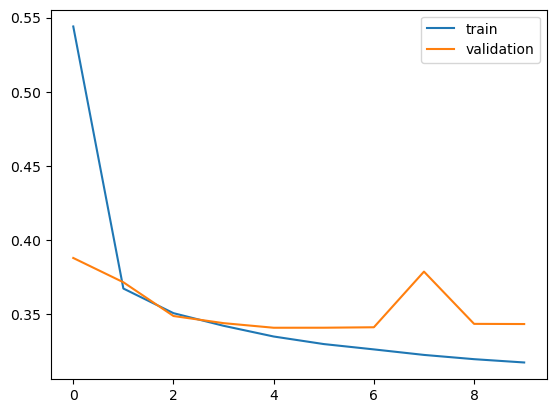

In [19]:
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='train')
sns.lineplot(x=range(len(val_losses)), y=val_losses, label='validation')

##### Testset Evaluation

In [20]:
# Set model to eval mode
model.eval()

# Test model
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device))


# Convert to numpy
y_pred = y_pred.cpu().numpy().squeeze()

In [22]:
# Model Accuracy
print('Log Listing Price')
regression_accuracy(y_pred, y_test)
threshold_accuracy(y_pred, y_test, p=.1)

# Upscaled
print('\n\nListing Price')
regression_accuracy(np.exp(y_pred), np.exp(y_test))
threshold_accuracy(np.exp(y_pred), np.exp(y_test), p=.1)

Log Listing Price
R2 Score: 0.6445440293754067
MSE: 0.3424740793134676
MAE 0.4386493189045186
RMSE 0.585212849579935
Threshold Accuracy 0.7049336701347795


Listing Price
R2 Score: 0.5344821598803832
MSE: 138439.88469456113
MAE 173.38138338280933
RMSE 372.0751062548543
Threshold Accuracy 0.16869512992174665


<Axes: >

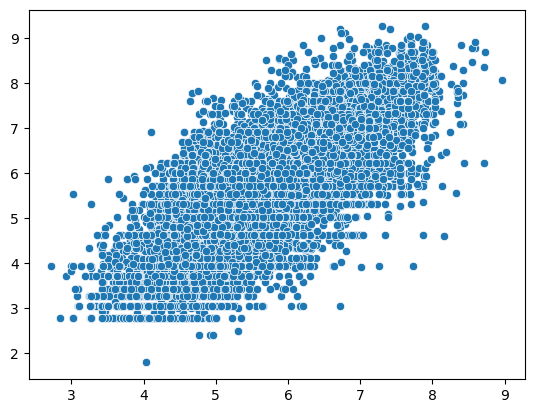

In [23]:
sns.scatterplot(x=y_pred, y=y_test)

Mean of residuals: -0.04089087611059402
Std of residuals: 0.5837825070729473


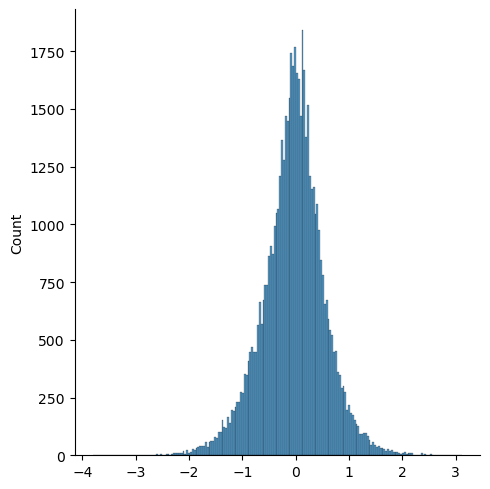

In [24]:
# Residuals
print('Mean of residuals:', np.mean(y_test - y_pred))
print('Std of residuals:', np.std(y_test - y_pred))
sns.displot(y_test - y_pred)
plt.show()

Generally we see the residuals behave as we'd like, but still sub-par performance and quite high standard deviation

In [25]:
# Saving model
torch.save(model.state_dict(), 'models/pickled_models/base_regression_net_log_price_1612.pt')

#### Explore Differences

In [26]:
# Extract test data
test_data = data.raw_df[data.raw_df.classified_id.isin(X_test.classified_id)]

# Add predictions
X_test_copy = X_test.copy()
X_test_copy['log_listing_price'] = y_pred
X_test_copy['listing_price_prediction'] = np.exp(y_pred)

# Add predictions to test data
test_data = test_data.iloc[:, :14].merge(X_test_copy[['classified_id', 'log_listing_price', 'listing_price_prediction']], on='classified_id')

# Calculate difference
test_data['difference'] = test_data['listing_price'] - test_data['listing_price_prediction']
test_data['percentage_correct'] = (test_data['listing_price_prediction'] / test_data['listing_price']) 


In [27]:
test_data.log_listing_price.sort_values(ascending=False)

40528    8.964846
36729    8.722543
40165    8.718304
34150    8.714073
20926    8.592502
           ...   
30720    2.994373
22682    2.994373
50405    2.924646
6977     2.841682
20707    2.718867
Name: log_listing_price, Length: 56611, dtype: float32

In [28]:
test_data.sort_values(by='percentage_correct', ascending=False).head(10)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,log_listing_price,listing_price_prediction,difference,percentage_correct
21750,30396678,2023-09-10,1553782,50,50,8,219,Louis Vuitton,Never used,Orange,Women,Women,Women,Crossbody bags,7.729867,2275.298340,-2225.298340,45.505967
48615,31745558,2023-11-16,2304480,20,20,1,1,Unassigned_Computere,"New, still with price",Grey,Electronics,Electronics,Electronics,Computere,6.724543,832.591064,-812.591064,41.629553
49181,30808649,2023-09-30,1064225,99,99,13,66,Dior,Good but used,Burgundy,Women,Women,Women,Belts,8.156680,3486.592285,-3387.592285,35.218104
19433,31572787,2023-11-06,2060059,50,50,0,1,Prada,Good but used,NaN,Women,Women,Women,Tasker,7.263828,1427.711060,-1377.711060,28.554221
21663,30683078,2023-09-24,2460469,6000,100,0,200,Prada,Never used,Black,Men,Men,Clothes,Jackets,7.869345,2615.852051,-2515.852051,26.158521
32848,32044349,2023-12-05,377401,20,20,0,3,Nike,Almost as new,NaN,Men,Men,Men,Sneakers,6.203710,494.580353,-474.580353,24.729018
45118,30558614,2023-09-17,2210278,20,20,0,0,Unassigned_Electronics,"New, still with price",Black,Electronics,Electronics,Electronics,Electronics,6.159616,473.246307,-453.246307,23.662315
5235,31949382,2023-11-29,58446,49,49,2,9,Apple,Good but used,White,Electronics,Electronics,Electronics,Parts & components,7.015204,1113.433716,-1064.433716,22.723137
38127,30390658,2023-09-09,202158,16,20,9,45,Nailster,Never used,NaN,Women,Women,Beauty & care,Nail care,6.047663,423.123138,-403.123138,21.156157
30145,31838882,2023-11-21,4941,865,11,20,180,H&M,"New, still with price",White,Women,Women,Clothes,Dresses,5.309289,202.206497,-191.206497,18.382409


In [30]:
# Average percentage correct
test_data.percentage_correct.mean()

1.2622277916492013

### Base Regression Preprocessing

In [31]:
# Reset dataset
data.reset_dataset()

In [33]:
# Apply base regression pipeline
data.apply_function(base_regression_pipeline)

In [35]:
data.head()

,classified_id,log_listing_price,brand_name,condition_name,subsubsubcategory_name
0,30343099,7.170120,6.880371,3,6.421452
1,30346312,5.860786,6.108272,3,5.040240
2,30364278,4.795791,5.161306,2,5.616803
3,30406315,6.111467,5.705055,5,5.423886
4,30420441,6.398595,6.880371,4,6.421452


In [36]:
# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(drop_helpers(data.df))

# Assigning X to data.df
data.df[drop_helpers(data.df).columns] = X

In [37]:
# Print head
data.df.head()

,classified_id,log_listing_price,brand_name,condition_name,subsubsubcategory_name
0,30343099,7.170120,1.863212,-0.166384,1.584302
1,30346312,5.860786,0.715890,-0.166384,-1.168418
2,30364278,4.795791,-0.691281,-1.093762,-0.019343
3,30406315,6.111467,0.116718,1.688371,-0.403822
4,30420441,6.398595,1.863212,0.760993,1.584302


In [39]:
# Split
X_train, X_test, X_val, y_train, y_test, y_val = data.stratify_train_test_split(val_size=0.2, return_splits=True, y_column='log_listing_price')

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create pytorch datasets
trainset = TensorDataset(X_train_tensor, y_train_tensor)
valset = TensorDataset(X_val_tensor, y_val_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)

# Create pytorch dataloaders
batch_size = 32
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=testset, batch_size=1, shuffle=False)


Dependent variable distribution is equal across all subsets


##### Model

In [40]:
# Neural network
class NewRegressionNN(nn.Module):
    def __init__(self, input_size):
        super(NewRegressionNN, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        return self.main(x)

In [41]:
# Get next batch
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

# Create model
new_model = NewRegressionNN(x.shape[1])

# Print model summary
summary(new_model, input_size=x.shape[1])

# Pass data through model
y_pred = new_model(x)

print(y_pred.squeeze().shape)

torch.Size([32, 4])
torch.Size([32])
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       640
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       33,024
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       32,896
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       129
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
torch.Size([32])


In [44]:
# Train model
device = torch.device('mps')

# Initialize the network
new_model = NewRegressionNN(input_size = x.shape[1])
new_model = new_model.to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

# Train new_model
new_train_losses, new_val_losses = train(new_model, criterion, optimizer, train_loader, val_loader, device, epochs=100, print_every=1, early_stopping=5)

Epoch 0, train loss: 446731283.9014839, val loss: 1.931187437937758
Epoch 1, train loss: 765832.8514353567, val loss: 11317.423781227932
Epoch 2, train loss: 1466876.3758371542, val loss: 2.164604878021499
Epoch 3, train loss: 19266.12025434335, val loss: 10.693928513823256
Epoch 4, train loss: 41472.44719165795, val loss: 9.843929141254748
Epoch 5, train loss: 2.4565015906059573, val loss: 0.9701714012414049
Epoch 6, train loss: 0.9709032998162728, val loss: 0.9721849795788695
Epoch 7, train loss: 0.9715277795380187, val loss: 0.9766674192611781
Epoch 8, train loss: 0.9725668247629128, val loss: 0.9732080834396815
Epoch 9, train loss: 0.9745314254312473, val loss: 0.9764314667653229
Epoch 10, train loss: 0.9761250794562704, val loss: 0.9804653461033341
Early stopping!


<Axes: >

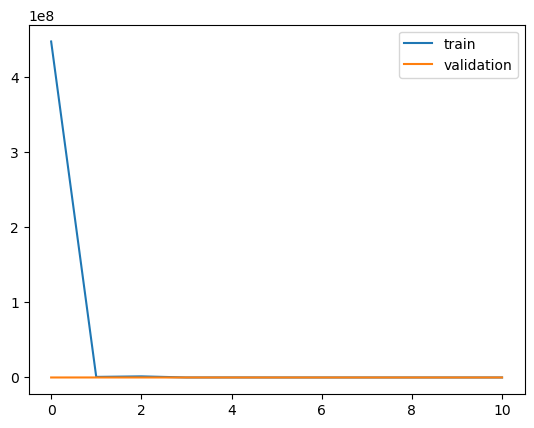

In [49]:
sns.lineplot(x=range(len(new_train_losses)), y=new_train_losses, label='train')
sns.lineplot(x=range(len(new_val_losses)), y=new_val_losses, label='validation')

In [52]:
# Test Prediciotn and Accuracy
# Set model to eval mode
new_model.eval()

# Test model
with torch.no_grad():
    y_pred = new_model(X_test_tensor.to(device))
    
# Convert to numpy
y_pred = y_pred.cpu().numpy().squeeze()

# Model Accuracy
regression_accuracy(y_pred, y_test)

R2 Score: -0.011779098270676913
MSE: 0.9748271059844348
MAE 0.7904750273588442
RMSE 0.9873333307371097


Mean of residuals: -0.10653123681769243
Std of residuals: 0.9815692545951751


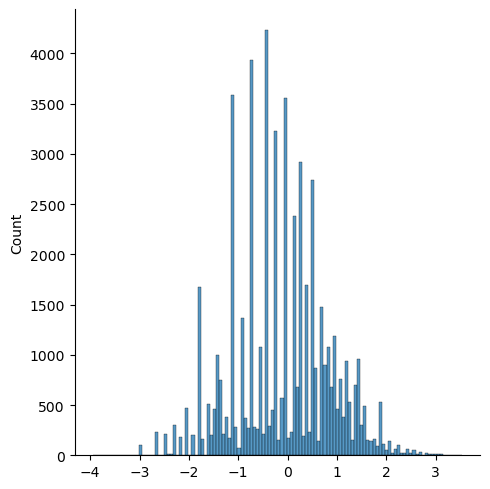

In [53]:
# Residuals
print('Mean of residuals:', np.mean(y_test - y_pred))
print('Std of residuals:', np.std(y_test - y_pred))

sns.displot(y_test - y_pred)
plt.show()


Compared to the first method, this method is far inferior. It's easy to understand, since the power of neural networks are better levaraged in the first attempt, due to the added diamensionality and granularity of the data from which the network can better learn the non-linear relationships between input and output. The last method, where the preprocessing was optimised for the regression task, don't have the same granularity and is more generalised - which helps regression perform better - but in this case, it's redundant and causes inferior results.